In [1]:
import torch
import torch.nn as nn
import time
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

# net

In [215]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.mlp = nn.Sequential(
            
            nn.Linear(64,128),
            nn.ReLU(),
    
            nn.Linear(128,32),
            nn.ReLU(),
    
            nn.Linear(32,2),
)

    def forward_once(self, x):
        output = self.mlp(x)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


# data

In [2]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist

In [3]:
df = pd.read_csv('changhai_auc.csv',index_col=0)
samples=df.columns
drugs=df.index

In [4]:
data=df.T.values
#X_=torch.from_numpy(X)

In [5]:
data.shape[0]

37

In [105]:
class Dataset(object):

    def __init__(self, x0, x1, label):
        self.size = label.shape[0]
        self.x0 = torch.from_numpy(x0)
        self.x1 = torch.from_numpy(x1)
        self.label = torch.from_numpy(label)

    def __getitem__(self, index):
        return (self.x0[index],
                self.x1[index],
                self.label[index])

    def __len__(self):
        return self.size

In [115]:
def create_pairs(data):
    x0_data = []
    x1_data = []
    d = []
    #print(data.shape)
    n = data.shape[0]
    for i in range(n):
        for j in range(i+1,n):
            x0_data.append(data[i])
            x1_data.append(data[j])
            x=np.vstack([data[i],data[j]])
            d.append(pdist(x)[0])

    x0_data = np.array(x0_data, dtype=np.float32)

    x1_data = np.array(x1_data, dtype=np.float32)
   
    d = np.array(d, dtype=np.float32)
 
    return x0_data, x1_data, d


def create_iterator(data,batchsize, shuffle=False):
    x0, x1, d = create_pairs(data)
    ret = Dataset(x0, x1, d)
    return ret

# train

In [212]:
def run(X,epoch=10,batchsize=64,model='',plot=False):
    #data
    train_iter = create_iterator(X,batchsize)
    #model
    model = SiameseNetwork()
    #loss and  optimizer
    learning_rate = 0.01
    weight_decay=5e-4
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=weight_decay)
    
    train_loader = torch.utils.data.DataLoader(train_iter,
        batch_size=batchsize, shuffle=True)
    
    loss_p=[]
    #train
    for i in range(epoch):
        train_loss = []
        model.train()
        start = time.time()
        start_epoch = time.time()
        for batch_idx, (x0, x1, labels) in enumerate(train_loader):
            labels = labels.float()
#             if args.cuda:
#                 x0, x1, labels = x0.cuda(), x1.cuda(), labels.cuda()
            x0, x1, labels = Variable(x0), Variable(x1), Variable(labels)
            output1, output2 = model(x0, x1)
            loss = loss_func(output1, output2, labels)
            train_loss.append(loss)
            optimizer.zero_grad()
            loss=loss/batchsize
            loss.backward()
            optimizer.step()

#             accuracy = []

#             for idx, logit in enumerate([output1, output2]):
#                 corrects = (torch.max(logit, 1)[1].data == labels.long().data).sum()
#                 accu = float(corrects) / float(labels.size()[0])
#                 accuracy.append(accu)

#             if batch_idx % batchsize == 0:
        end = time.time()
        took = end - start
        print('Train Epoch: {} \tLoss:{:.6f}\tTook: {:.2f}\t'.format(
                        i,sum(train_loss)/len(train_loader.dataset), 
                        took))
        start = time.time()
        torch.save(model.state_dict(), './model/model-epoch-%s.pth' % i)
        end = time.time()
        took = end - start_epoch
        #print('Train epoch: {} \tTook:{:.2f}'.format(epoch, took))
        if plot:
            loss_p.append(sum(train_loss)/len(train_loader.dataset))
    if plot:
        x_values=list(range(1,epoch+1))
       
        plt.plot(x_values,loss_p, label="train loss")
        x_major_locator=MultipleLocator(1)
        ax=plt.gca()
        ax.xaxis.set_major_locator(x_major_locator)
        plt.legend()
        plt.draw()

In [206]:
def loss_func(output1,output2,d):
    temp=F.pairwise_distance(output1, output2, p=2)
    temp=temp-d
    loss=sum(torch.pow(temp,2))
    return loss

Train Epoch: 0 	Loss:0.468546	Took: 0.07	
Train Epoch: 1 	Loss:0.130708	Took: 0.06	
Train Epoch: 2 	Loss:0.072424	Took: 0.06	
Train Epoch: 3 	Loss:0.066316	Took: 0.07	
Train Epoch: 4 	Loss:0.061463	Took: 0.07	
Train Epoch: 5 	Loss:0.057313	Took: 0.06	
Train Epoch: 6 	Loss:0.056431	Took: 0.07	
Train Epoch: 7 	Loss:0.056196	Took: 0.08	
Train Epoch: 8 	Loss:0.056662	Took: 0.08	
Train Epoch: 9 	Loss:0.054821	Took: 0.07	
Train Epoch: 10 	Loss:0.055314	Took: 0.06	
Train Epoch: 11 	Loss:0.055288	Took: 0.07	
Train Epoch: 12 	Loss:0.056066	Took: 0.07	
Train Epoch: 13 	Loss:0.054832	Took: 0.08	
Train Epoch: 14 	Loss:0.056187	Took: 0.06	
Train Epoch: 15 	Loss:0.054311	Took: 0.06	
Train Epoch: 16 	Loss:0.055082	Took: 0.06	
Train Epoch: 17 	Loss:0.056046	Took: 0.05	
Train Epoch: 18 	Loss:0.057222	Took: 0.05	
Train Epoch: 19 	Loss:0.055948	Took: 0.05	


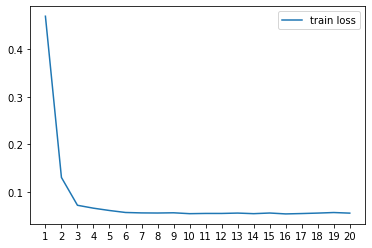

In [218]:
run(data,epoch=20,batchsize=64,model='',plot=True)

# test

In [6]:
class SiameseNetwork2(nn.Module):
    def __init__(self):
        super(SiameseNetwork2, self).__init__()
        self.mlp = nn.Sequential(
            
            nn.Linear(64,128),
            nn.ReLU(),
    
            nn.Linear(128,32),
            nn.ReLU(),
    
            nn.Linear(32,2),
)

    def forward(self, x):
        output = self.mlp(x)
        return output

In [7]:
model=SiameseNetwork2()
model.load_state_dict(torch.load("model/model-epoch-6.pth"))

<All keys matched successfully>

In [8]:
test_data = np.array(data, dtype=np.float32)
test_data=torch.from_numpy(test_data)
output=model(test_data).detach().numpy()


In [9]:
y=output[:,1]
x=output[:,0]

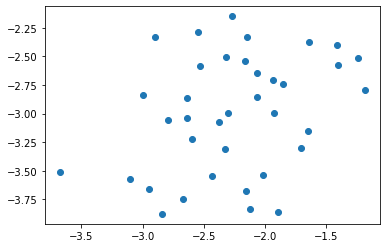

In [10]:
plt.scatter(x,y, label="point")

In [23]:
drugs
samples

Index(['PC-101', 'PC-102', 'PC-104', 'PC-105', 'PC-109', 'PC-111', 'PC-112',
       'PC-115', 'PC-116', 'PC-117', 'PC-119', 'PC-121', 'PC-13', 'PC-130',
       'PC-134', 'PC-135', 'PC-136', 'PC-139', 'PC-14', 'PC-16', 'PC-18',
       'PC-2', 'PC-22', 'PC-27', 'PC-40', 'PC-5', 'PC-52', 'PC-56', 'PC-64',
       'PC-78', 'PC-8', 'PC-81', 'PC-97', 'PC-98', 'PC-G', 'PC-I', 'PC-L'],
      dtype='object')

## 结果

In [24]:
label=pd.read_csv('drug64_sample.txt',index_col=0,sep='\t')

In [48]:
label.loc['5-FU','res_names']
len(label.loc['5-FU','res_names'].split(sep=','))+len(label.loc['5-FU','sen_names'].split(sep=','))


37

In [44]:
sample=[]
for i in samples:
    sample.append(i.replace("-", "."))

In [57]:
for drug in drugs:
    list0=label.loc[drug,'res_names'].split(sep=',')
    list1=label.loc[drug,'sen_names'].split(sep=',')
    for i in list0:
        labels.loc[drug,i]=0
    for i in list1:
        labels.loc[drug,i]=1

In [56]:
labels = pd.DataFrame(columns=sample, index=drugs)

<ipython-input-152-a5c7ab7efd35>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


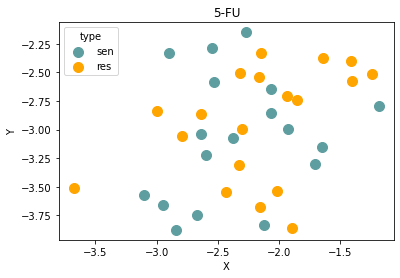

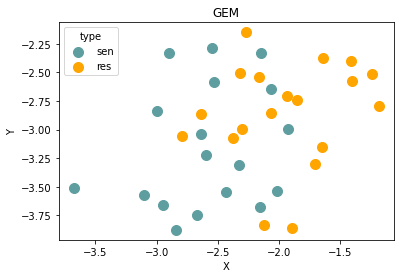

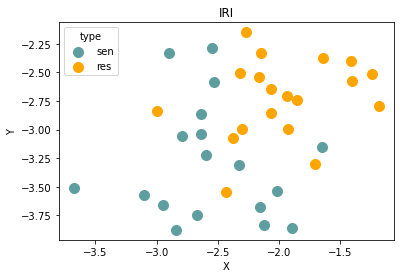

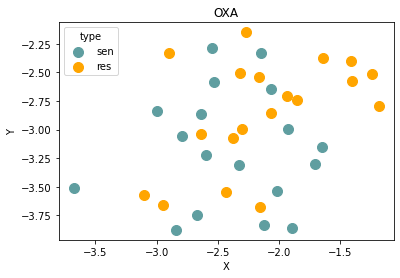

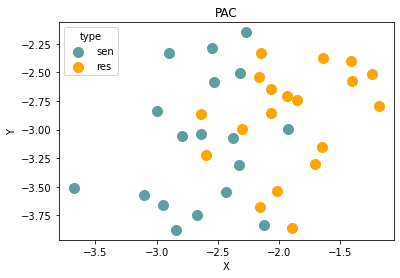

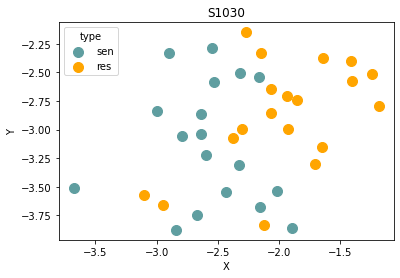

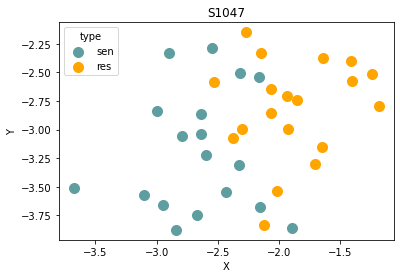

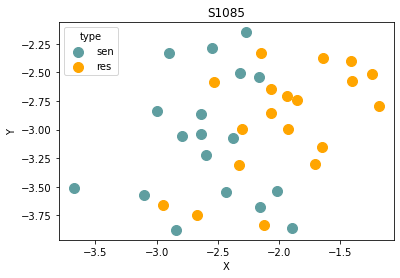

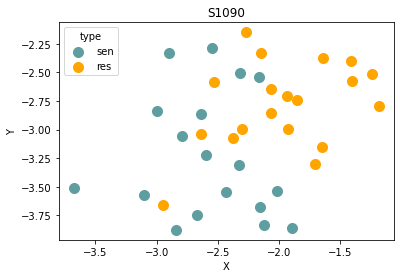

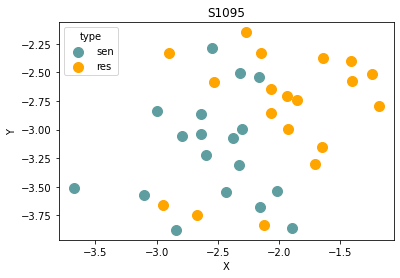

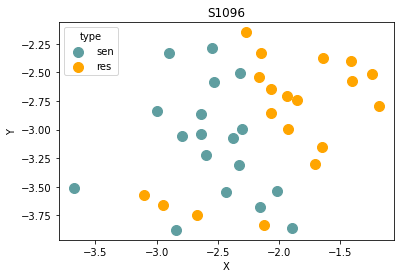

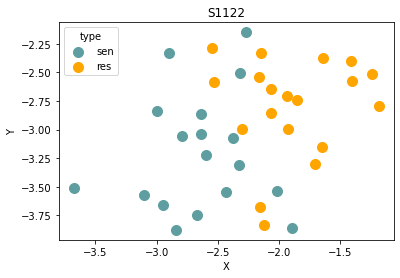

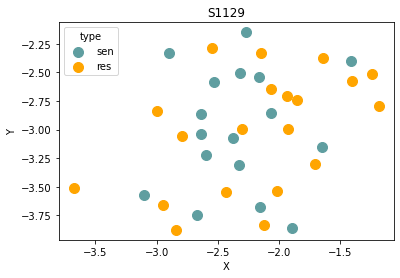

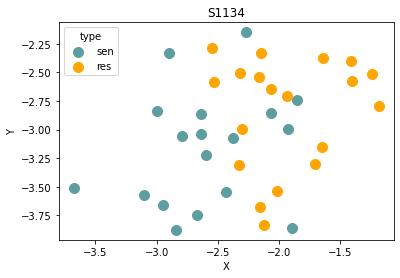

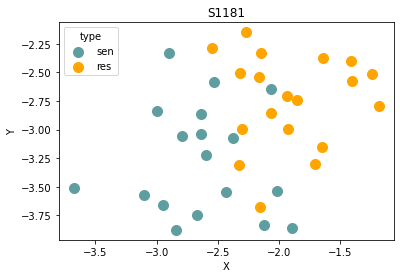

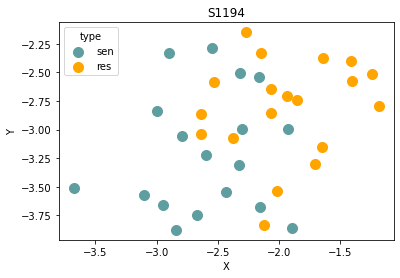

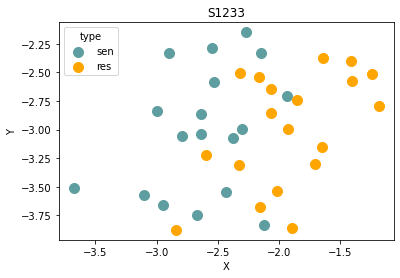

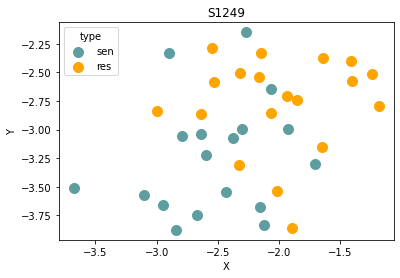

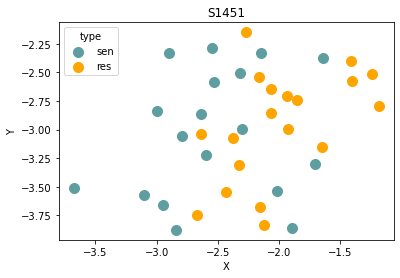

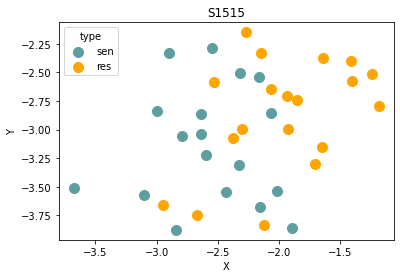

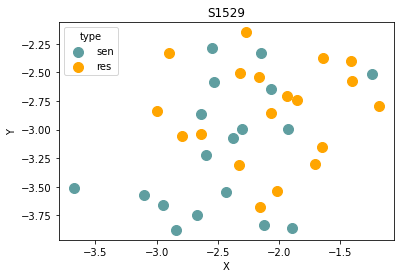

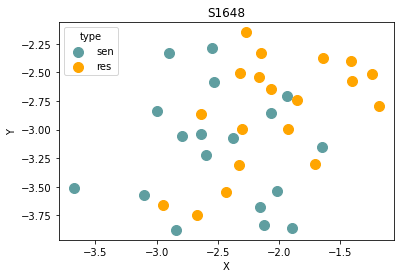

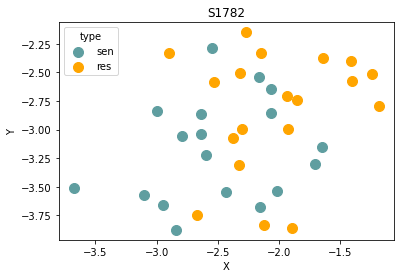

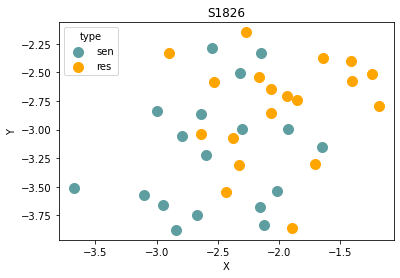

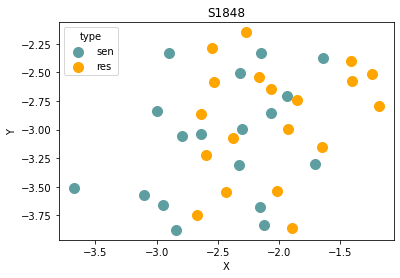

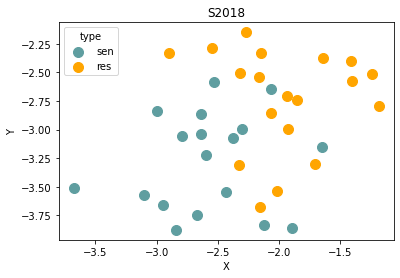

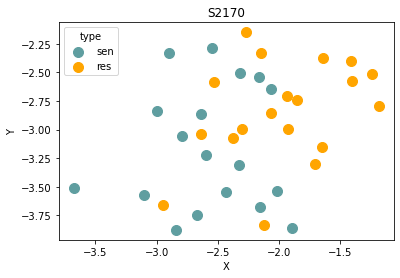

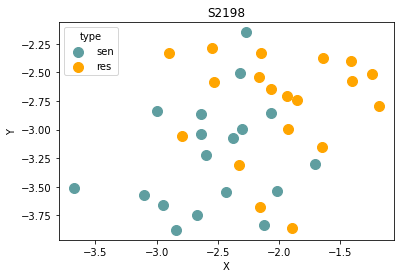

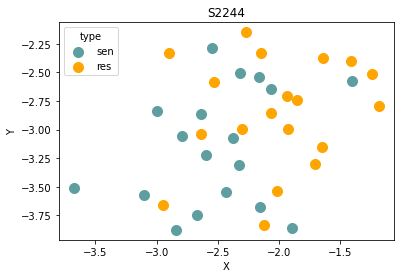

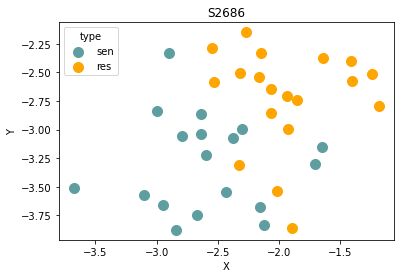

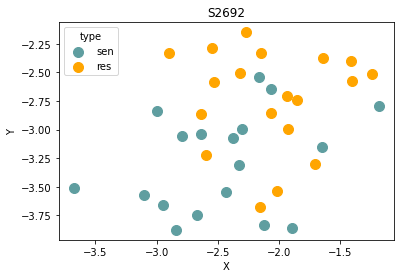

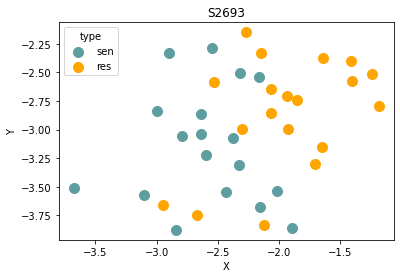

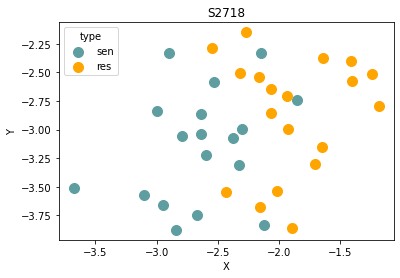

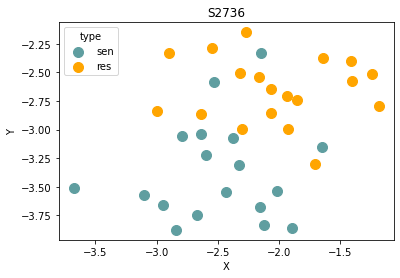

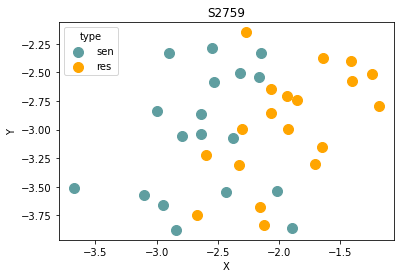

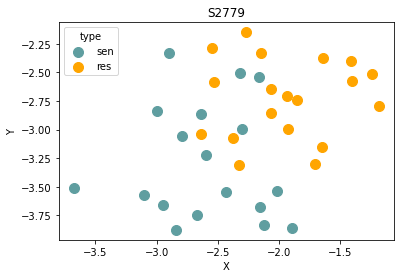

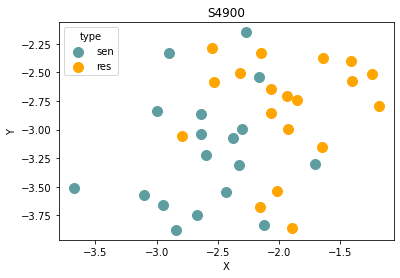

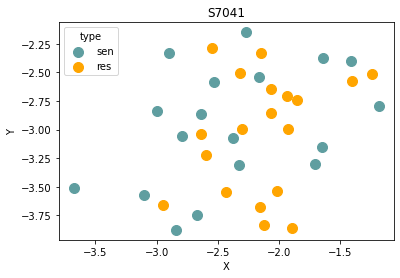

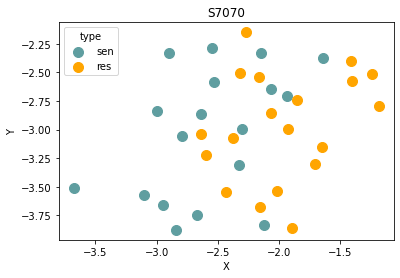

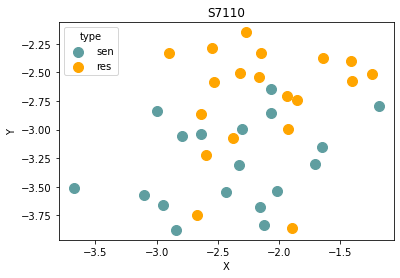

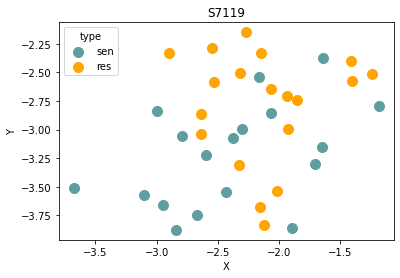

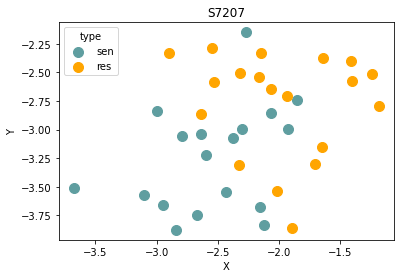

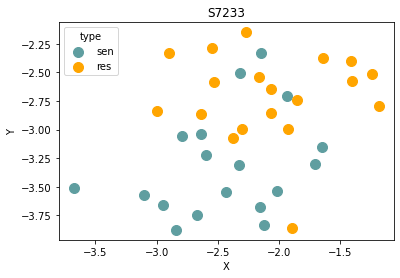

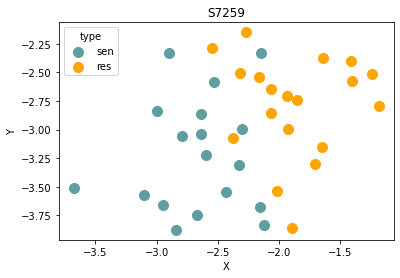

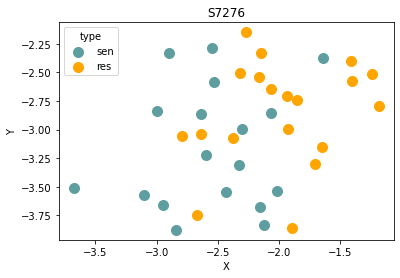

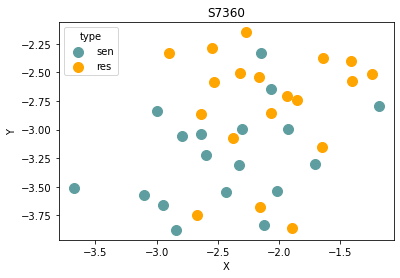

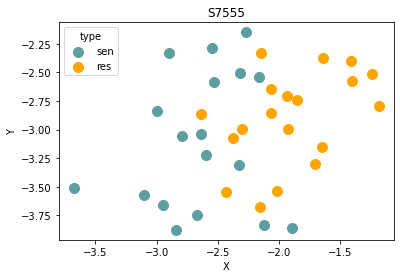

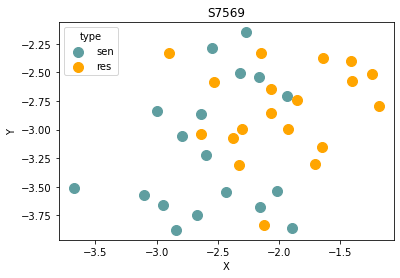

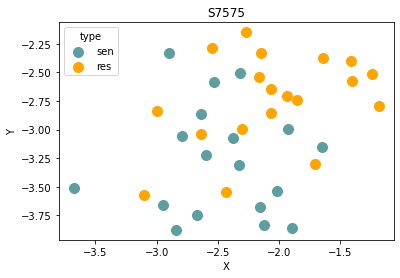

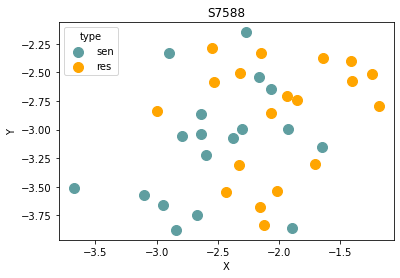

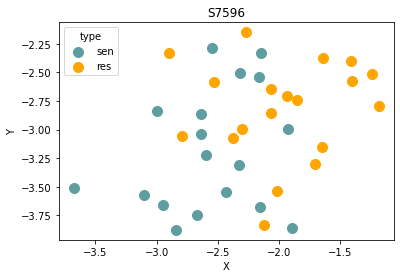

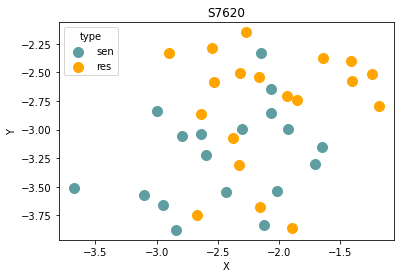

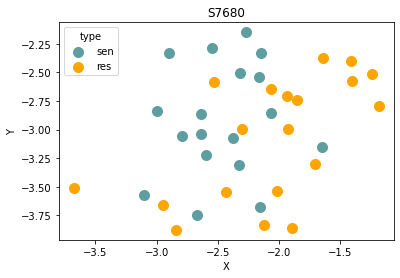

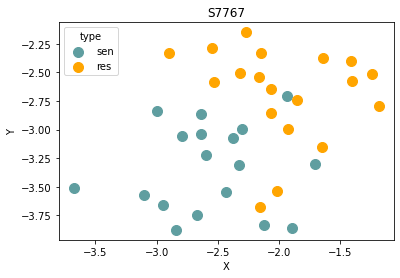

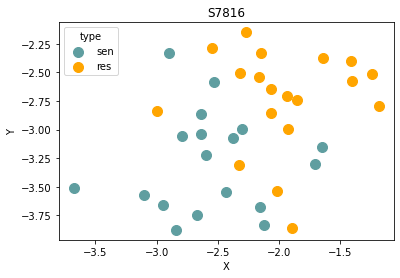

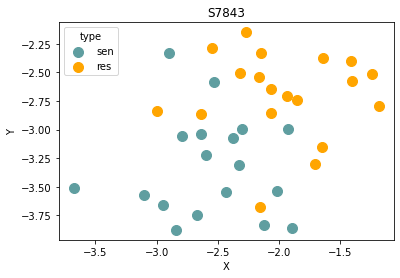

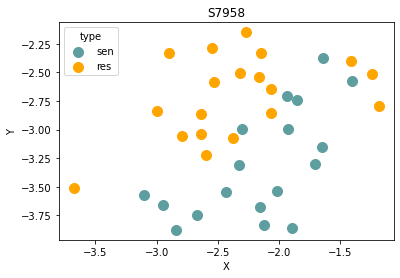

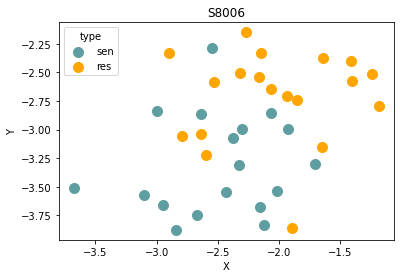

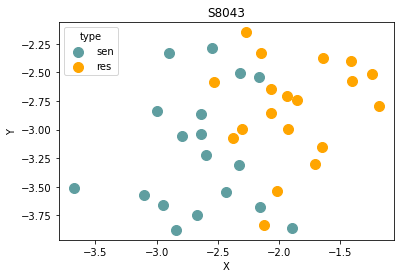

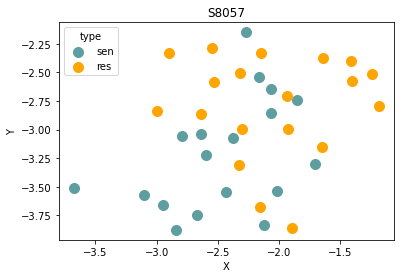

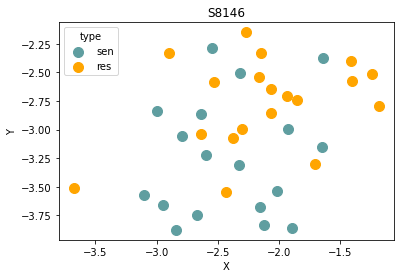

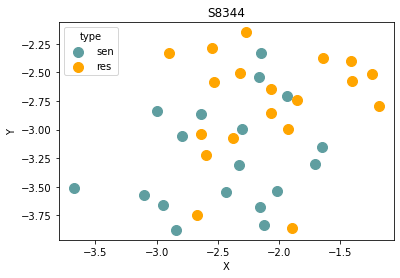

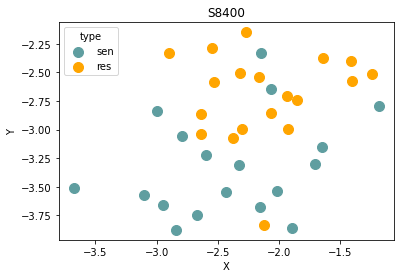

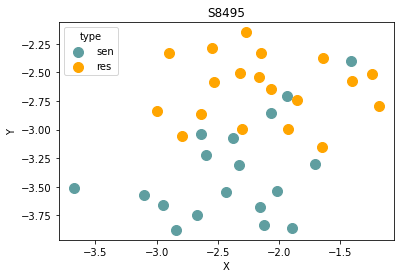

In [152]:
#x,y
for drug in drugs:
    color=labels.loc[drug].values
    
    
    temp=pd.DataFrame([x,y,color], index = ["x", "y", "c"], columns = sample).T
    sen=temp[temp.c==1]
    res=temp[temp.c==0]
    
    fig = plt.figure()  
    ax1 = fig.add_subplot(111)  
#设置标题  
    ax1.set_title(drug)  
#设置X轴标签  
    plt.xlabel('X')  
#设置Y轴标签  
    plt.ylabel('Y')  
#画散点图  

    ax1.scatter(x=sen.x,y=sen.y,c='#5F9EA0', s=100,label='sen')
    ax1.scatter(x=res.x,y=res.y,c='#FFA500', s=100,label='res')
#设置图标  
    plt.legend(title="type") 
           
#显示所画的图  
    #plt.show()
    plt.savefig('result/'+drug+'.jpg')

## output 之间的距离与d比较

In [127]:
a,b,din=create_pairs(data)
a,b,dout=create_pairs(output)

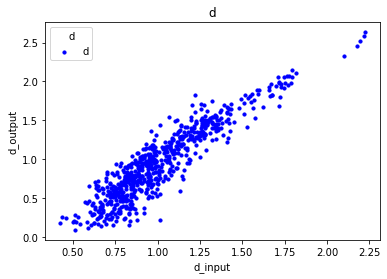

In [149]:
fig = plt.figure()  
ax1 = fig.add_subplot(111)  
#设置标题  
ax1.set_title("d")  
#设置X轴标签  
plt.xlabel('d_input')  
#设置Y轴标签  
plt.ylabel('d_output')  
#画散点图  

ax1.scatter(x=din,y=dout,c='blue', s=10,label='d')
#ax1.plot(din,y2,c='#FFA500')
#设置图标  
plt.legend(title="d") 
           
#显示所画的图  
plt.show()